<a href="https://colab.research.google.com/github/dainilliniad/small311qlab/blob/neurowave/%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import os
import numpy as np
import torch #
import torchvision #
import matplotlib.pyplot as plt #
from time import time #
from torchvision import datasets, transforms #
import pandas as pd #
from google.colab import drive #
from torch.utils.data import Dataset #
from torch.utils.data import DataLoader #
from tqdm import tqdm #
from torch.autograd import Variable #
import torch.nn as nn #
from torch import tensor
import matplotlib
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
correlation1=np.load('/content/cor1(2).npy') #тут указать свой путь до
correlation2=np.load('/content/cor2(2).npy')
correlation3=np.load('/content/cor3(2).npy')
pitog=np.load('/content/pitog(2).npy')
tetta=np.load('/content/tetitog(2).npy')   #файлов numpy, созданных в первой части проекта

In [ ]:
class LAADataset(Dataset):
    def __init__(self, Corr_data_g1, Corr_data_g2, Corr_data_g3, Theta_data, P_data, x_0, x_end):
      self.LAAdata = []
      self.len_data = x_end-x_0
      for obj in tqdm(range(self.len_data)):
        self.LAAdata.append((tensor([Corr_data_g1[obj],Corr_data_g2[obj],Corr_data_g3[obj]]),tensor([(Theta_data[obj]+np.pi/2)/np.pi,P_data[obj]])))

    def __len__(self):
      return self.len_data

    def __getitem__(self, idx):
      return self.LAAdata[idx][0],self.LAAdata[idx][1]

In [ ]:
#объявление модели, число нейронов в слоях
model = torch.nn.Sequential(
        torch.nn.Linear(3, 50, bias=False),
        nn.BatchNorm1d(50),
        torch.nn.ReLU(),

        torch.nn.Linear(50, 300, bias=False),
        nn.BatchNorm1d(300),
        torch.nn.ReLU(),

        torch.nn.Linear(300, 1000, bias=False),
        nn.BatchNorm1d(1000),
        torch.nn.ReLU(),

        torch.nn.Linear(1000, 300, bias=False),
        nn.BatchNorm1d(300),
        torch.nn.ReLU(),

        torch.nn.Linear(300, 25, bias=False),
        nn.BatchNorm1d(25),
        torch.nn.ReLU(),

        torch.nn.Linear(25, 2)
        )

In [ ]:
# Длина обучающей и тестирующей выборок
lenTestData = 1000 #длина тестовой выборки
lenTrainData = 15000 #длина обучающей выборки
batch_size = 250 #размер батча
epoches=15 #число эпох
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

testDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog, 0,lenTestData)
trainDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog,lenTestData,lenTrainData+lenTestData)

testDataloader = DataLoader(testDatasets, batch_size=batch_size, shuffle=False, num_workers=2)
trainDataloader = DataLoader(trainDatasets, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
#подсчет средней абсолютной ошибки
def maeLAA(originalData,localModel):
  localModel.eval()
  mae = 0
  with torch.no_grad():
    for corf, value in trainDataloader:
      corf, value = corf.float(), value.float()
      predict = localModel(corf)
      mae = mae + abs(predict-value).mean().item()
  return mae/len(value)

In [ ]:
#обучение модели по эпохам
model = model.float()
cae_train = []
cae_test = []
loss_train = []
loss_test = []
for epoch in range(epoches):
  model.train()
  for corf, tettab in trainDataloader:
    tettab = tettab.float()
    output = model(corf.float())
    loss = criterion(output, tettab)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train.append(loss.item())
  cae_train.append(maeLAA(trainDataloader,model))

  model.eval()
  for corf, tettab in testDataloader:
    tettab = tettab.float()
    output = model(corf.float())
    loss = criterion(output, tettab)
  loss_test.append(loss.item())
  cae_test.append(maeLAA(trainDataloader,model))
  print('Epoch: ', epoch, 'Loss: ', loss.item())

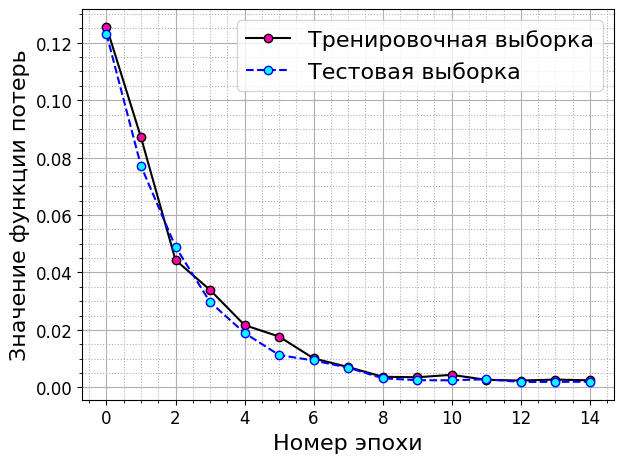

In [ ]:
def plotLoss(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtrain, linestyle='-', marker='o', color='k',
         markerfacecolor='#ff00aaff', label='Тренировочная выборка')
  ax.plot(localtest, linestyle='--', marker='o', color='b',
         markerfacecolor='#00ffffff',  label='Тестовая выборка')
  ax.legend(fontsize=16)
  ax.minorticks_on()
  ax.set_xlabel('Номер эпохи', fontsize=16)
  ax.set_ylabel(r'Значение функции потерь', fontsize=16)
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  fig.show()

plotLoss(loss_test,loss_train,'loss')


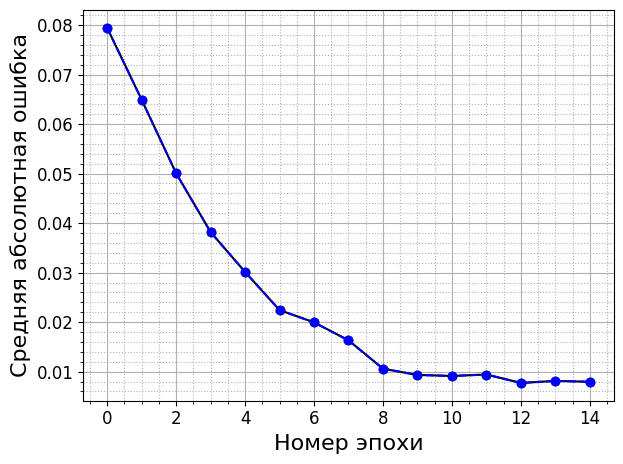

In [ ]:
def plotLoss(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtrain, linestyle='-', marker='o', color='k')
  ax.plot(localtest, linestyle='--', marker='o', color='b')
  ax.minorticks_on()
  ax.set_xlabel('Номер эпохи', fontsize=16)
  ax.set_ylabel(r'Средняя абсолютная ошибка', fontsize=16)
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  fig.show()

plotLoss(cae_test,cae_test, 'test')


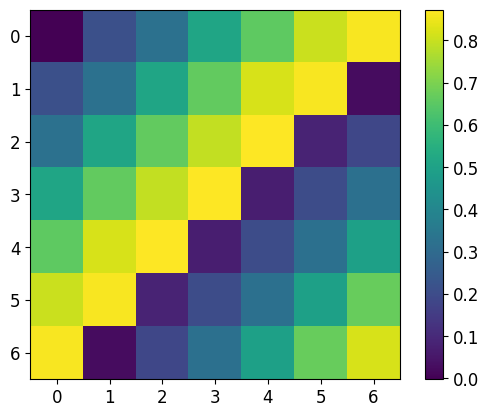

In [ ]:
x=[[1.0000, 0.9446, 0.8344, 0.7508, 0.9167, 0.9887, 1.0000],
        [0.9446, 0.8344, 0.7508, 0.7494, 0.9156, 0.9990, 0.9336],
        [0.8344, 0.7508, 0.7494, 0.8419, 0.9970, 0.5035, 0.7932],
        [0.7508, 0.7494, 0.8419, 0.9960, 0.0700, 0.3779, 0.6684],
        [0.9167, 0.9156, 0.9970, 0.0700, 0.3779, 0.6684, 0.8755],
        [0.9887, 0.9990, 0.5035, 0.3779, 0.6684, 0.8755, 0.9777],
        [1.0000, 0.9336, 0.7932, 0.6684, 0.8755, 0.9777, 1.0000]]
y=[[5.0000e-01, 2.7166e-01, 1.7088e-01, 2.4801e-01, 4.7901e-01, 7.6699e-01,
         9.9601e-01],
        [2.7166e-01, 1.7088e-01, 2.4801e-01, 4.7704e-01, 6.8890e-01, 9.9256e-01,
         2.5102e-01],
        [1.7088e-01, 2.4801e-01, 4.7704e-01, 7.6509e-01, 9.9253e-01, 1.2517e-05,
         9.3849e-02],
        [2.4801e-01, 4.7704e-01, 7.6509e-01, 9.9595e-01, 2.4491e-01, 9.0422e-02,
         1.1024e-01],
        [4.7901e-01, 6.8890e-01, 9.9253e-01, 2.4491e-01, 9.0422e-02, 1.1024e-01,
         2.9927e-01],
        [7.6699e-01, 9.9256e-01, 1.2517e-05, 9.0422e-02, 1.1024e-01, 2.9927e-01,
         5.8124e-01],
        [9.9601e-01, 2.5102e-01, 9.3849e-02, 1.1024e-01, 2.9927e-01, 5.8124e-01,
         8.4445e-01]]
z=[[0.0000, 0.2214, 0.4976, 0.7472, 0.7473, 0.8413, 0.9960],
        [0.2214, 0.4976, 0.7472, 0.9146, 0.9144, 0.9970, 0.0664],
        [0.4976, 0.7472, 0.9146, 0.9881, 0.9990, 0.4965, 0.3728],
        [0.7472, 0.9146, 0.9881, 1.0000, 0.9300, 0.7881, 0.6636],
        [0.7473, 0.9144, 0.9990, 0.9300, 0.7881, 0.6636, 0.6225],
        [0.8413, 0.9970, 0.4965, 0.7881, 0.6636, 0.6225, 0.6863],
        [0.9960, 0.0664, 0.3728, 0.6636, 0.6225, 0.6863, 0.8300]]
t=[]
for i in range(7):
  for j in range(7):
    t.append([x[i][j], y[i][j], z[i][j]])

model1=model(torch.tensor(t))
p=[]
tet=[]
p1=[]
tet1=[]
for i in range(49):

  if len(p1)!=7:
     p1.append(float(model1[i][1]))
     tet1.append(float(model1[i][0])*np.pi/2)

  else:

    p.append(p1)
    tet.append(tet1)
    p1=[]
    tet1=[]
    p1.append(float(model1[i][1]))
    tet1.append(float(model1[i][0])*np.pi/2)


p.append(p1)
tet.append(tet1)

plt.imshow(p)
plt.colorbar()